In [403]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline

In [525]:
states = gpd.read_file("cb_2016_us_state_500k/cb_2016_us_state_500k.shp")
bounds_usa = [
            [
              -129.7265625,
              24.5271348225978
            ],
            [
              -63.45703124999999,
              24.5271348225978
            ],
            [
              -63.45703124999999,
              50.401515322782366
            ],
            [
              -129.7265625,
              50.401515322782366
            ],
            [
              -129.7265625,
              24.5271348225978
            ]
          ]

usa_box = Polygon(bounds_usa)
states.crs = {'init': 'epsg:4326', 'proj': 'latlong'}
states = states[states.within(usa_box)]
states.head(1)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."


In [526]:
pm25 = pd.read_csv("pm25_annual_fixed.csv")
points = pm25.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
pm25 = gpd.GeoDataFrame(pm25, geometry=points)
pm25.crs = {'init': 'epsg:4326', 'proj': 'latlong'}
pm25 = pm25[pm25.within(usa_box)]
pm25.head(1)

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,50th Percentile,10th Percentile,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,geometry
0,1,3,10,88101,1,30.497478,-87.880258,NAD83,PM2.5 - Local Conditions,24 HOUR,...,5.7,3.8,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2017-05-18,POINT (-87.880258 30.497478)


In [527]:
powerplants = pd.read_csv("powerplants.csv")
points = powerplants.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
powerplants = gpd.GeoDataFrame(powerplants, geometry=points)
powerplants.crs = {'init': 'epsg:4326', 'proj': 'latlong'}
powerplants = powerplants[powerplants.within(usa_box)]
powerplants.head(1)

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,Zip,Street_Add,PrimSource,...,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
0,2,Bankhead Dam,Alabama Power Co,195,Electric Utility,Northport,Tuscaloosa,35476,19001 Lock 17 Road,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 56 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,33.458665,-87.356823,POINT (-87.35682299999999 33.458665)


In [407]:
carbon = pd.read_csv("Total Carbon Dioxide Emissions-StateRankings.csv")
carbon.head(1)

,Rank,State,"Total Carbon Dioxide Emissions, million metric tons",Note: Rankings are based on the full source data values.
0,1,TX,642.0,NaN


## GROUP ONE: You'll just need to plot, you won't need to join or do much analysis

### 1. Make a map of power plants in the US, color coded by type

(-127.65372665000001,
 -64.059236349999992,
 23.322281750000002,
 50.625409249999997)

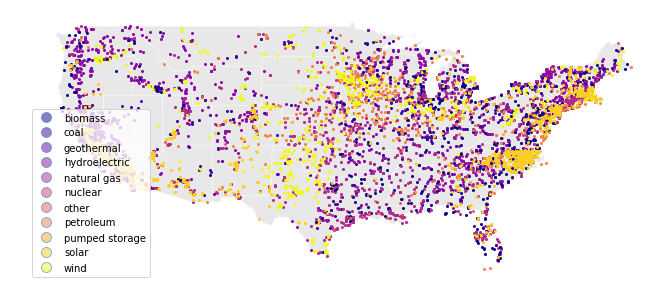

In [11]:
ax = states.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
powerplants.plot(figsize=(40,15), column='PrimSource', legend=True, cmap='plasma', ax=ax)
ax.axis('off')

### 3. Make a map of air quality stations, color coded by worst air quality ever 

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

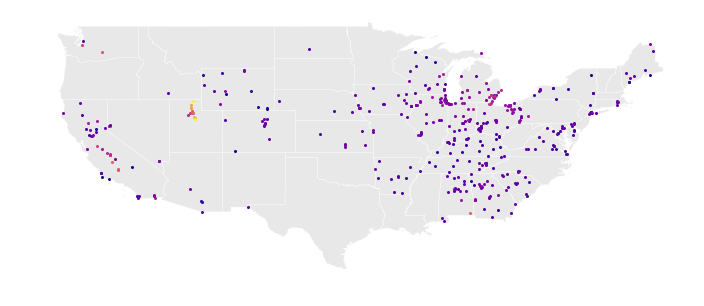

In [12]:
ax = states.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
pm25.plot(figsize=(40,15), column='1st Max Value', cmap='plasma', ax=ax)
ax.axis('off')

### 5. Map all of the nuclear power plants in red, with the rest of the plants as dark grey.

(-127.65372665000001,
 -64.059236349999992,
 23.322281750000002,
 50.625409249999997)

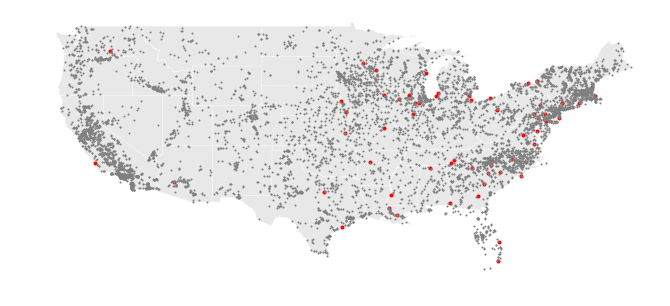

In [13]:
ax = states.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
powerplants[powerplants['PrimSource'] == 'nuclear'].plot(figsize=(40,15), markersize=3, color='red', ax=ax)
powerplants[powerplants['PrimSource'] != 'nuclear'].plot(figsize=(40,15), markersize=1, color='grey', ax=ax)
ax.axis('off')

## GROUP TWO: For most of these you'll need a spatial join

### 2. Which power plants are in New York?

In [410]:
neighborhoods = gpd.read_file("nynta_14d/nynta.shp")

In [479]:
neighborhoods = neighborhoods.to_crs({'init': 'epsg:5070', 'proj': 'latlong'})

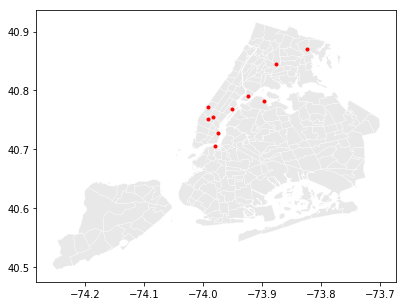

In [16]:
ax = neighborhoods.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
powerplants[powerplants['City'] == 'New York'].plot(markersize=3, color='red', ax=ax)

### 4. Which state produces the most energy from coal?

In [17]:
states_with_plants = gpd.sjoin(states.reset_index(), powerplants, how='inner', op='intersects')

In [18]:
states_with_plants['coal_sum'] = states_with_plants.groupby('index')['Coal_MW'].sum()
states_with_plants['coal_sum'] = states_with_plants['coal_sum'].fillna(0)

In [19]:
states_with_plants.groupby('NAME')['coal_sum'].mean().sort_values(ascending=False).head()

NAME
Kansas          16111.4
Virginia        15189.9
Iowa            14644.6
South Dakota    13313.4
Missouri        13092.7
Name: coal_sum, dtype: float64

### 6. Map states with nuclear power plants in red, and states without in grey. Do the same thing for solar.

In [20]:
states_with_nuclear = states_with_plants[states_with_plants['PrimSource'] == 'nuclear']['NAME'].value_counts().to_frame().reset_index()

In [21]:
states_with_nuclear = states_with_nuclear.rename(columns={'index': 'NAME', 'NAME': 'COUNT'})

In [22]:
states_with_nuclear = states.merge(states_with_nuclear, how='left', on='NAME')
states_with_nuclear['COUNT'].fillna(value=0, inplace=True)

In [23]:
states_with_nuclear = gpd.GeoDataFrame(states_with_nuclear)

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

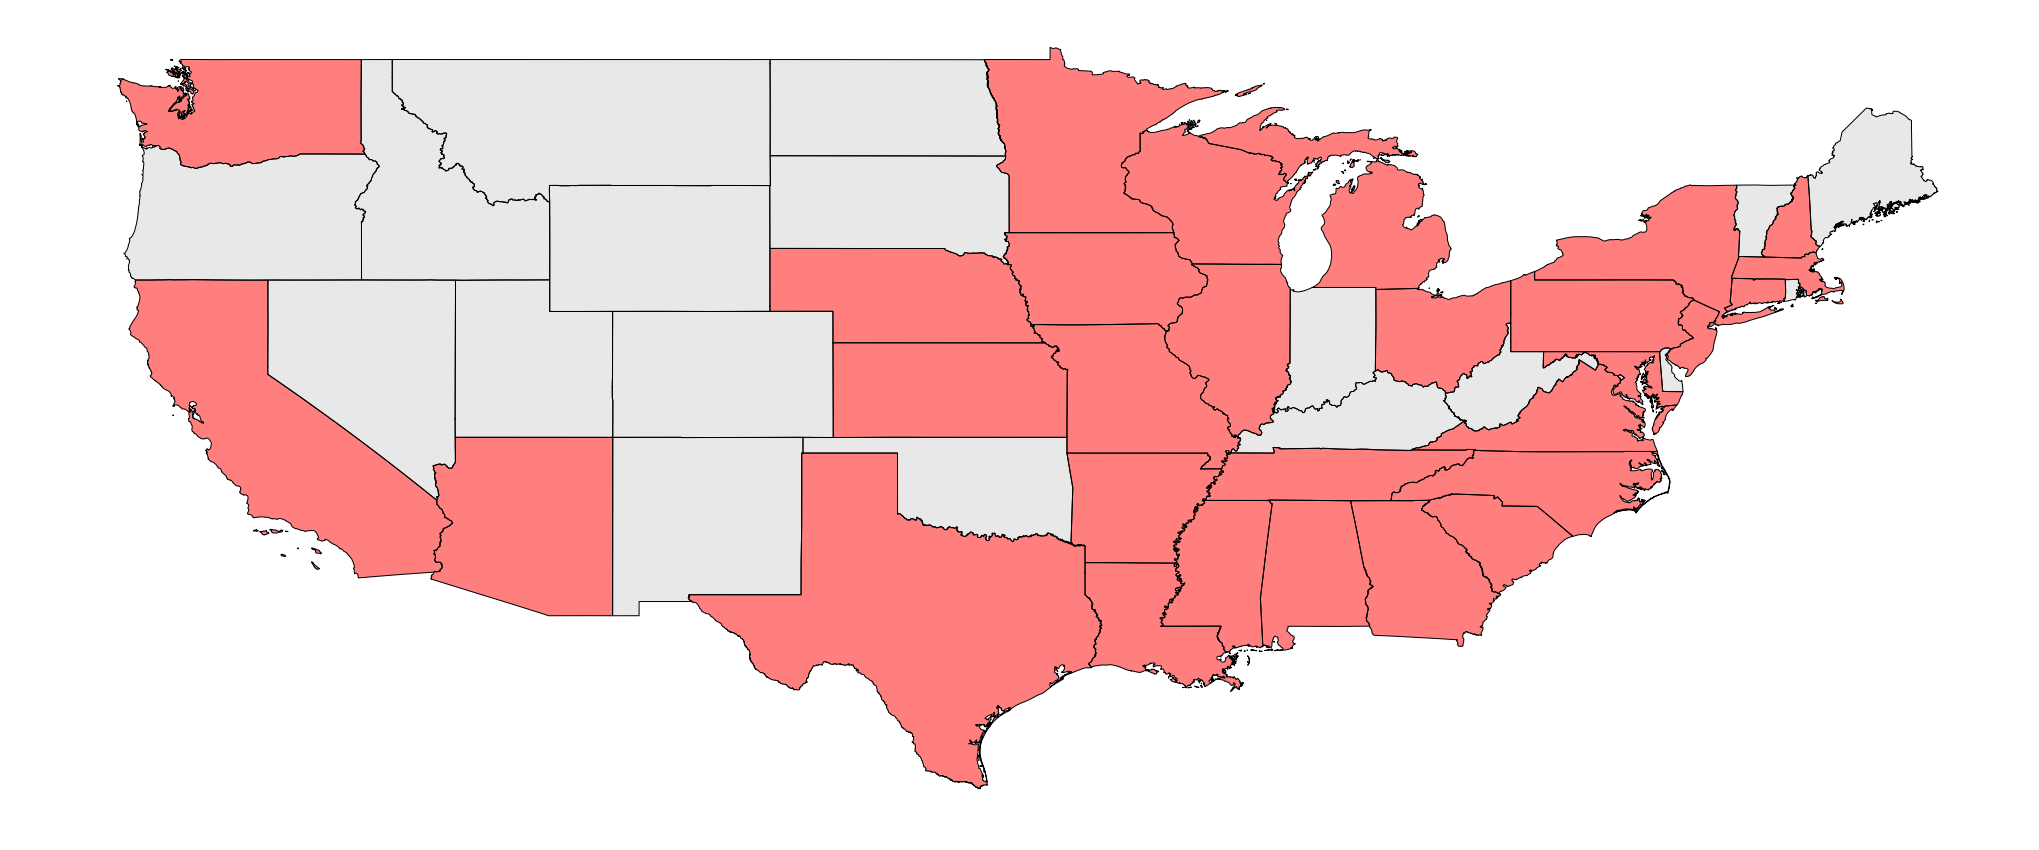

In [24]:
ax = states_with_nuclear[states_with_nuclear['COUNT'] != 0].plot(figsize=(40,15), color='red')
states_with_nuclear[states_with_nuclear['COUNT'] == 0].plot(figsize=(40,15), color='lightgrey', ax=ax)
ax.axis('off')

In [25]:
states_with_nuclear.crs

In [26]:
states_with_solar = states_with_plants[states_with_plants['PrimSource'] == 'solar']['NAME'].value_counts().to_frame().reset_index()
states_with_solar = states_with_solar.rename(columns={'index': 'NAME', 'NAME': 'COUNT'})

In [27]:
states_with_solar = states.merge(states_with_solar, how='left', on='NAME')
states_with_solar['COUNT'].fillna(value=0, inplace=True)

In [28]:
states_with_solar = gpd.GeoDataFrame(states_with_solar)

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

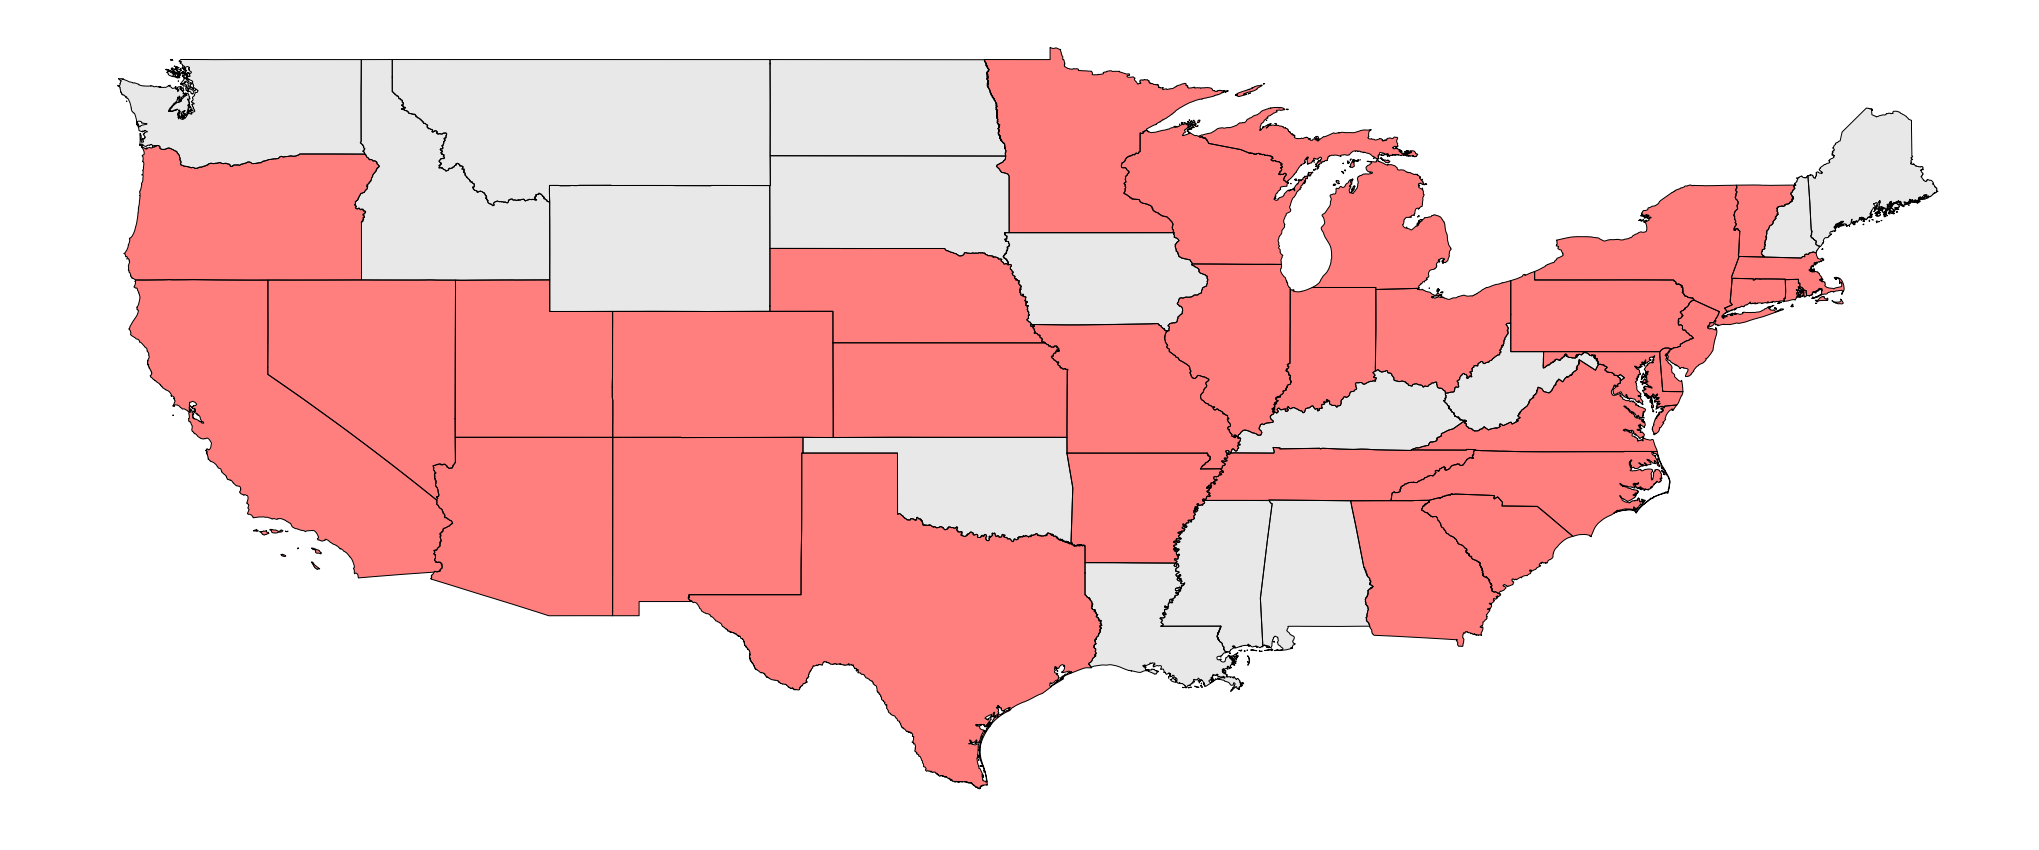

In [29]:
ax = states_with_solar[states_with_solar['COUNT'] != 0].plot(figsize=(40,15), color='red')
states_with_solar[states_with_solar['COUNT'] == 0].plot(figsize=(40,15), color='lightgrey', ax=ax)
ax.axis('off')

### 8. Make a map of total wind (or solar or coal) energy produced by each state, with little being a light color and high emissions being a brighter/darker color.

In [30]:
coal = states_with_plants[['NAME', 'coal_sum']]
coal = coal.groupby('NAME')['coal_sum'].mean().to_frame().reset_index()

In [31]:
states_with_coal = states.merge(coal, how='left', on='NAME')
states_with_coal.head(1)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,coal_sum
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",7979.4


(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

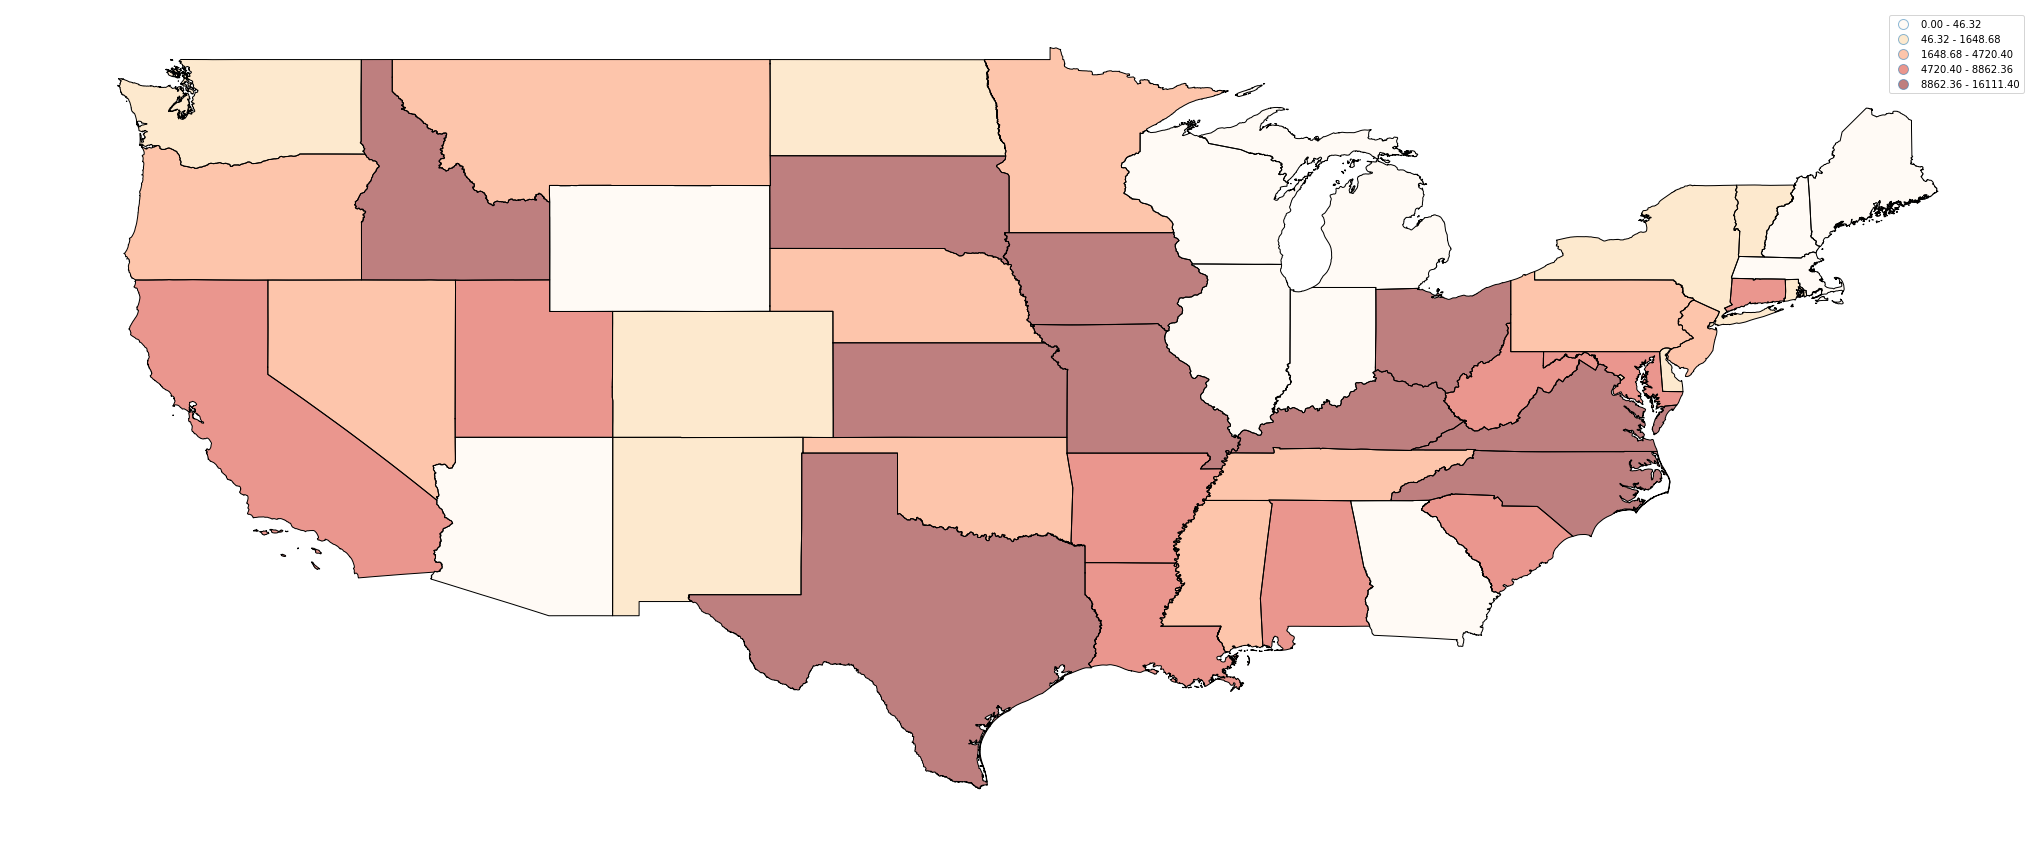

In [32]:
ax = states_with_coal.plot(figsize=(40,15), column='coal_sum', scheme='quantiles', legend=True, cmap='OrRd')
ax.axis('off')

### 10. Make a map of worst air quality measured in each state, with high quality being light red and low quality being dark red 

In [33]:
states_with_pm25 = gpd.sjoin(states.reset_index(), pm25, how='inner', op='intersects')
states_with_pm25['max_mean'] = states_with_pm25.groupby('index')['1st Max Value'].median()

In [34]:
states_with_pm25['max_mean'].fillna(value=0, inplace=True)

In [35]:
air = states_with_pm25[['NAME', 'max_mean']]
air = air.groupby('NAME')['max_mean'].mean().to_frame().reset_index()

In [36]:
states_with_air = states.merge(air, how='left', on='NAME')
states_with_air['max_mean'].fillna(value=0, inplace=True)

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

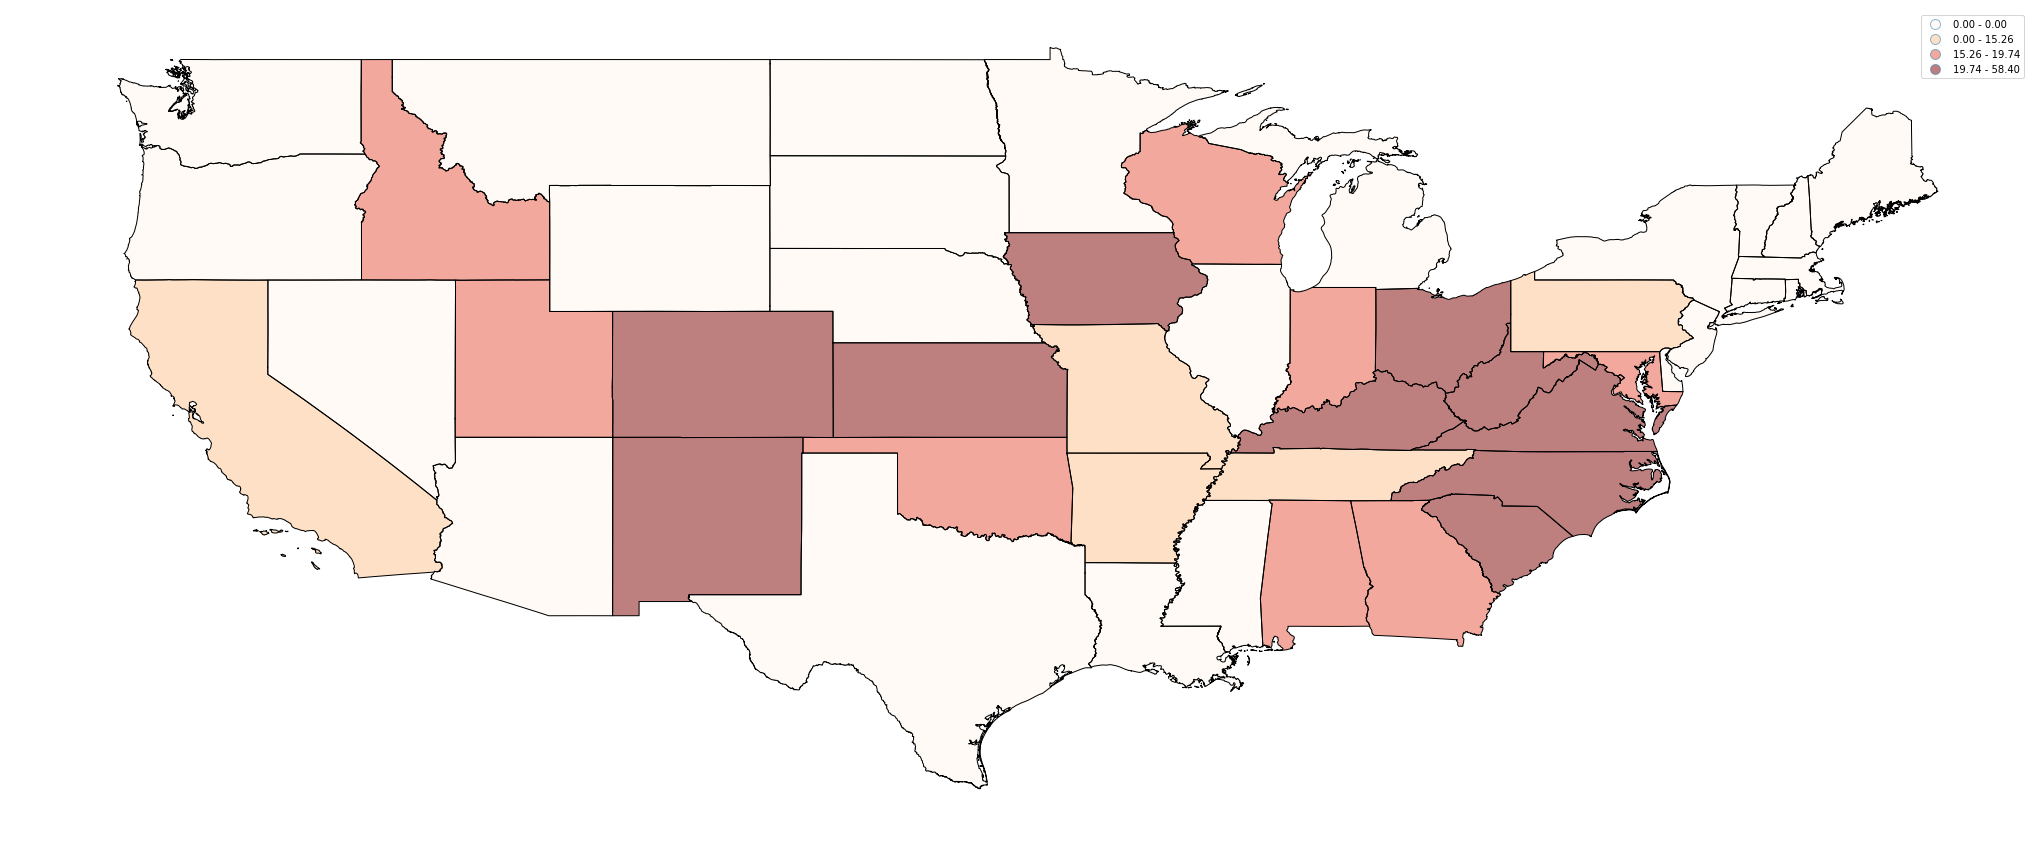

In [37]:
ax = states_with_air.plot(figsize=(40,15), column='max_mean', scheme='quantiles', legend=True, cmap='OrRd')
ax.axis('off')

### 13. Which states have the most renewable plants, as a % of total plants? (include hydro, wind, solar)

In [38]:
total = states_with_plants.groupby('NAME')['NAME'].value_counts().to_frame()

In [39]:
total = total.rename(columns={'NAME': 'COUNT'}).reset_index(level=1)

In [40]:
renewable = ['hydro', 'wind', 'solar']
renewable_plants = states_with_plants[states_with_plants['PrimSource'].isin(renewable)]
states_with_renewable = renewable_plants['NAME'].value_counts() / states_with_plants['NAME'].value_counts()

In [41]:
states_with_renewable = states_with_renewable.to_frame().reset_index().rename(columns={'index': 'NAME', 'NAME': 'percent'})

In [42]:
states_with_renewable = states.merge(states_with_renewable, how='left', on='NAME')
states_with_renewable['percent'].fillna(value=0, inplace=True)

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

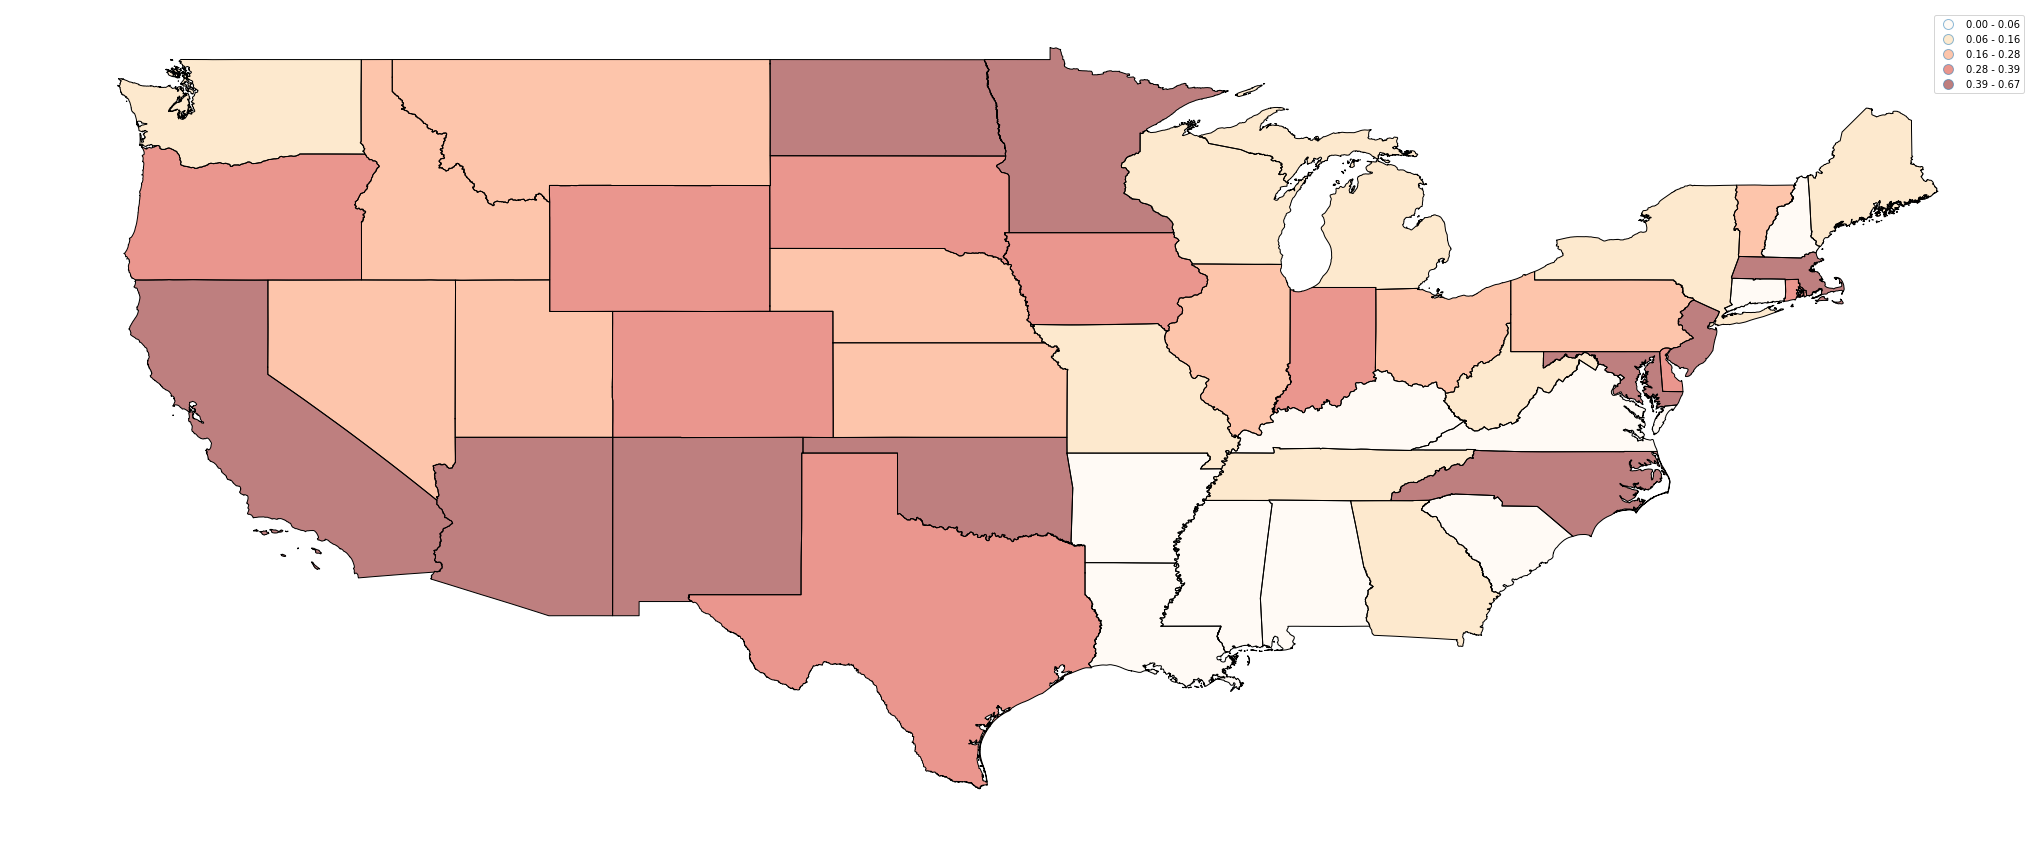

In [43]:
ax = states_with_renewable.plot(figsize=(40,15), column='percent', scheme='quantiles', legend=True, cmap='OrRd')
ax.axis('off')

## GROUP THREE: Buffers, or more interesting/complicated analysis

### 1. Do states with coal power plants have dirtier air?

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

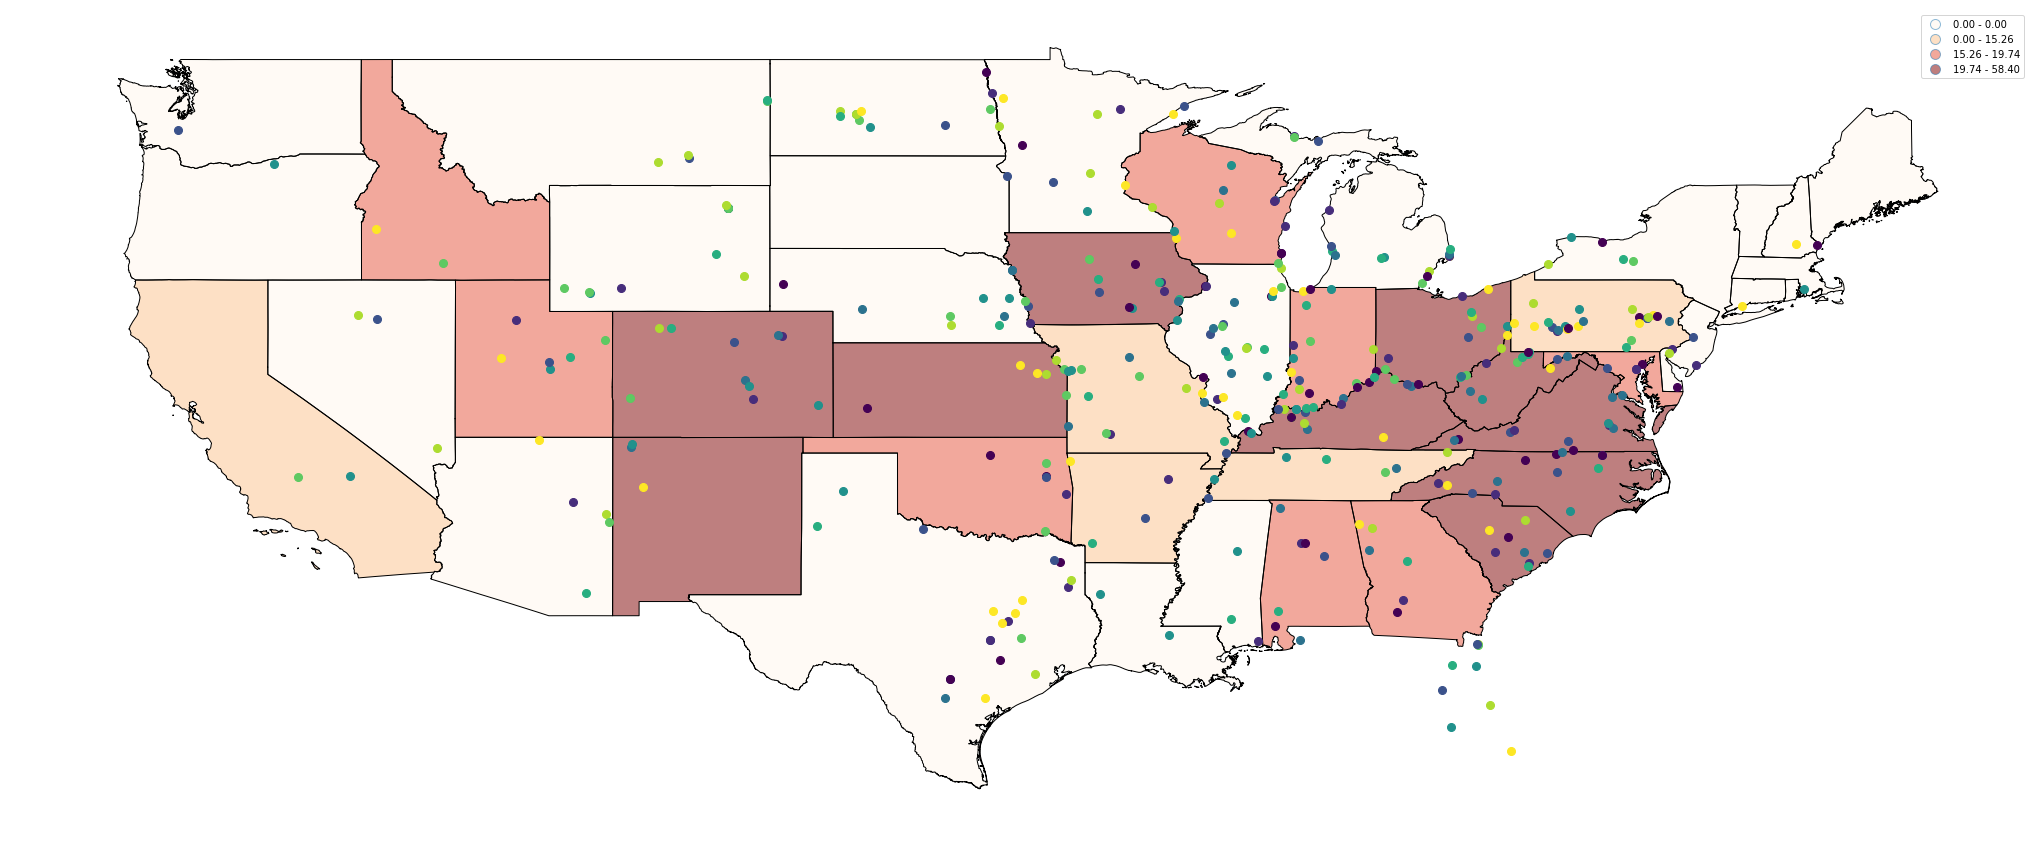

In [44]:
ax = states_with_air.plot(figsize=(40,15), column='max_mean', scheme='quantiles', legend=True, cmap='OrRd')
powerplants[powerplants['PrimSource'] == 'coal'].plot(markersize=8, figsize=(40,15), legend=True, ax=ax)
ax.axis('off')

### 2. Which power plants are within 75 miles of New York City? 

In [500]:
nyc_center = gpd.GeoDataFrame(geometry=[Point(-74.0, 40.7)])
nyc_center.crs = {'init': 'epsg:4326'}

In [501]:
nyc_center = nyc_center.to_crs({'init': 'epsg:3395'})
states = states.to_crs({'init': 'epsg:3395'})

In [502]:
buffered_nyc = nyc_center.buffer(120701)

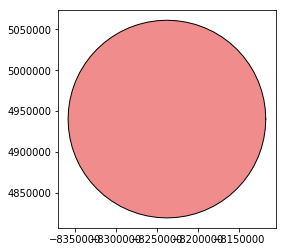

In [503]:
buffered_nyc.plot()

In [504]:
powerplants = powerplants.to_crs({'init': 'epsg:3395'})

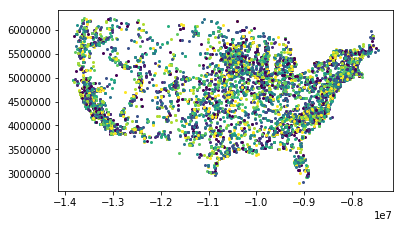

In [505]:
powerplants.plot()

In [514]:
buffered_nyc

0    POLYGON ((-8116941.318702244 4940322.380756882...
dtype: object

In [517]:
powerplants[powerplants.within(buffered_nyc.loc[0])]

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,Zip,Street_Add,PrimSource,...,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
344,542,Cos Cob,Connecticut Jet Power LLC,22379,IPP Non-CHP,Greenwich,Fairfield,6430,Sound Shore Drive,petroleum,...,0.0,NaN,NaN,Petroleum = 95.6 MW,Petroleum Liquids,"EIA-860, EIA-860M and EIA-923",201607,41.028900,-73.598900,POINT (-8192992.070945063 4988549.900230863)
362,568,Bridgeport Station,PSEG Power Connecticut LLC,15452,IPP Non-CHP,Bridgeport,Fairfield,6604,1 Atlantic Street,coal,...,0.0,NaN,NaN,"Coal = 383.4 MW, Petroleum = 16.9 MW",Conventional Steam Coal; Petroleum Liquids;,"EIA-860, EIA-860M and EIA-923",201607,41.170600,-73.184400,POINT (-8146850.142011249 5009402.536996153)
1148,2390,Sayreville,NRG REMA LLC,17235,IPP Non-CHP,Sayerville,Middlesex,8872,River Road,natural gas,...,0.0,NaN,NaN,"Natural Gas = 150 MW, Petroleum = 50 MW",Natural Gas Fired Combustion Turbine; Petroleu...,"EIA-860, EIA-860M and EIA-923",201607,40.476525,-74.352336,POINT (-8276864.182810381 4907690.437342524)
1150,2398,Bergen Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Ridgefield,Bergen,7657,Victoria Terrace,natural gas,...,0.0,NaN,NaN,Natural Gas = 1223 MW,Natural Gas Fired Combined Cycle,"EIA-860, EIA-860M and EIA-923",201607,40.837500,-74.024400,POINT (-8240358.514277601 4960455.041965267)
1152,2401,PSEG Essex Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Newark,Essex,7105,155 Raymond Boulevard,natural gas,...,0.0,NaN,NaN,Natural Gas = 81 MW,Natural Gas Fired Combustion Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.737200,-74.120600,POINT (-8251067.449291912 4945765.040610355)
1153,2403,PSEG Hudson Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Jersey City,Hudson,7306,Duffield and Van Keuren Avenue,natural gas,...,0.0,NaN,NaN,Natural Gas = 620 MW,Natural Gas Steam Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.747800,-74.072200,POINT (-8245679.585937517 4947316.467424445)
1154,2404,PSEG Kearny Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Kearny,Hudson,7032,Hackensack Avenue,natural gas,...,0.0,NaN,NaN,Natural Gas = 445 MW,Natural Gas Fired Combustion Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.737283,-74.096464,POINT (-8248380.642062125 4945777.187607292)
1155,2406,PSEG Linden Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Linden,Union,7036,Wood Avenue South,natural gas,...,0.0,NaN,NaN,Natural Gas = 1601.6 MW,Natural Gas Fired Combustion Turbine; Natural ...,"EIA-860, EIA-860M and EIA-923",201607,40.621700,-74.207200,POINT (-8260707.71719461 4928876.458336063)
1156,2408,PSEG Mercer Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Hamilton Township,Mercer,8611,Lamberton Road,coal,...,0.0,NaN,NaN,Coal = 632 MW,Conventional Steam Coal,"EIA-860, EIA-860M and EIA-923",201607,40.179200,-74.733900,POINT (-8319339.692995429 4864444.07738149)
1158,2411,PSEG Sewaren Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Sewaren,Middlesex,7077,751 Cliff Road,natural gas,...,0.0,NaN,NaN,Natural Gas = 450.6 MW,Natural Gas Steam Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.555800,-74.246900,POINT (-8265127.100979103 4919253.646925259)


(-14210347.848541735,
 -7131041.5710879602,
 2792959.8650698527,
 6475256.1445158478)

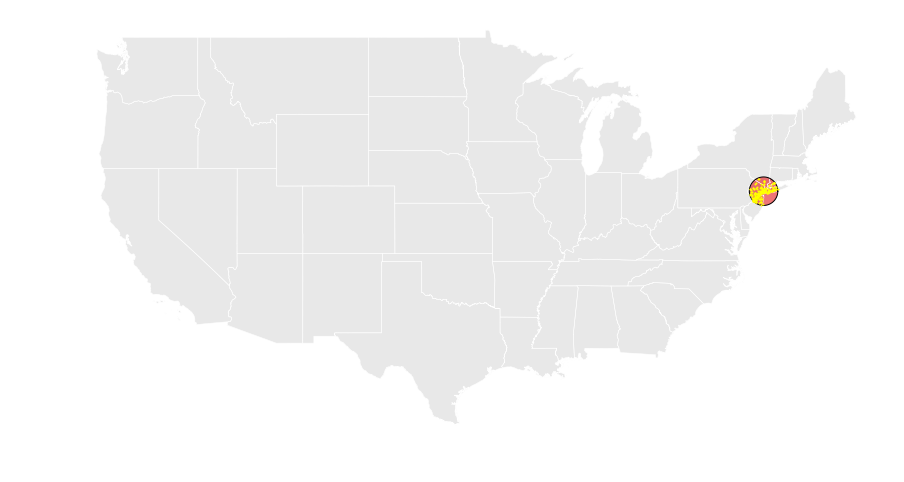

In [523]:
ax = states.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(20,8))
buffered_nyc.plot(alpha=0.6, ax=ax)
powerplants[powerplants.within(buffered_nyc.loc[0])].plot(markersize=1, color='yellow', ax=ax)
ax.axis('off')

### 3. Map all of the power plants in New York, New Jersey, Pennsylvania and Connecticut. Have a nice bottom layer of those 4 states.

In [129]:
states_names = ['New York', 'New Jersey', 'Pennsylvania', 'Connecticut']

four_states = states[states['NAME'].isin(states_names)]

In [354]:
powerplants = powerplants.to_crs(four_states.crs)

In [191]:
four_states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
6,0400000US09,12542638347,1815476291,09,00,Connecticut,09,01779780,CT,"(POLYGON ((-72.761427 41.242333, -72.759733 41..."
21,0400000US34,19050755048,3541927612,34,00,New Jersey,34,01779795,NJ,"POLYGON ((-75.559102 39.629056, -75.5594459999..."
25,0400000US42,115882226263,3396805575,42,00,Pennsylvania,42,01779798,PA,"POLYGON ((-80.519891 40.906661, -80.519091 40...."
43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,"(POLYGON ((-72.0368298202051 41.2498425393847,..."


In [355]:
plants_in_four = gpd.sjoin(four_states, powerplants, how='inner', op='intersects')

In [359]:
plants_in_four['geometry'] = plants_in_four.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

(-80.956535849999995, -71.35034915, 38.624152450000004, 45.320216549999998)

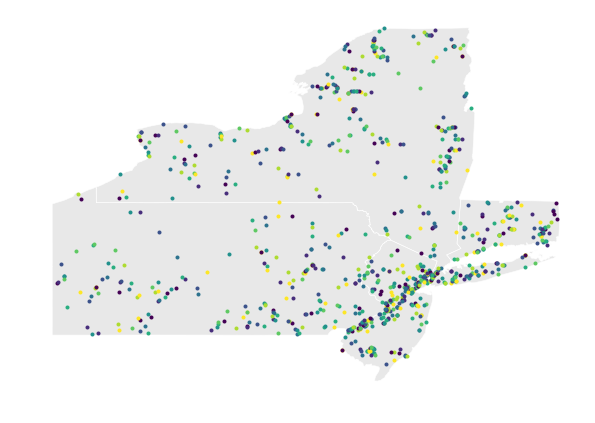

In [365]:
ax = four_states.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(10,10))
plants_in_four.plot(markersize=3, ax=ax)
ax.axis('off')

### 4. What is the most popular power source by state?

In [206]:
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."
5,0400000US08,268429343790,1175112870,08,00,Colorado,08,01779779,CO,"POLYGON ((-109.060253 38.599328, -109.059541 3..."


In [224]:
most_popular = states_with_plants.groupby('NAME')['PrimSource'].value_counts().groupby(level=0).nlargest(1).to_frame().reset_index(level=1)

In [234]:
most_popular = most_popular.rename(columns={'PrimSource': 'count'})

In [237]:
most_popular = most_popular.reset_index(level=1)

In [238]:
states_with_most_popular = states.merge(most_popular, how='left', on='NAME')

(-127.65372665000001, -64.059236349999992, 24.66002795, 50.561707049999995)

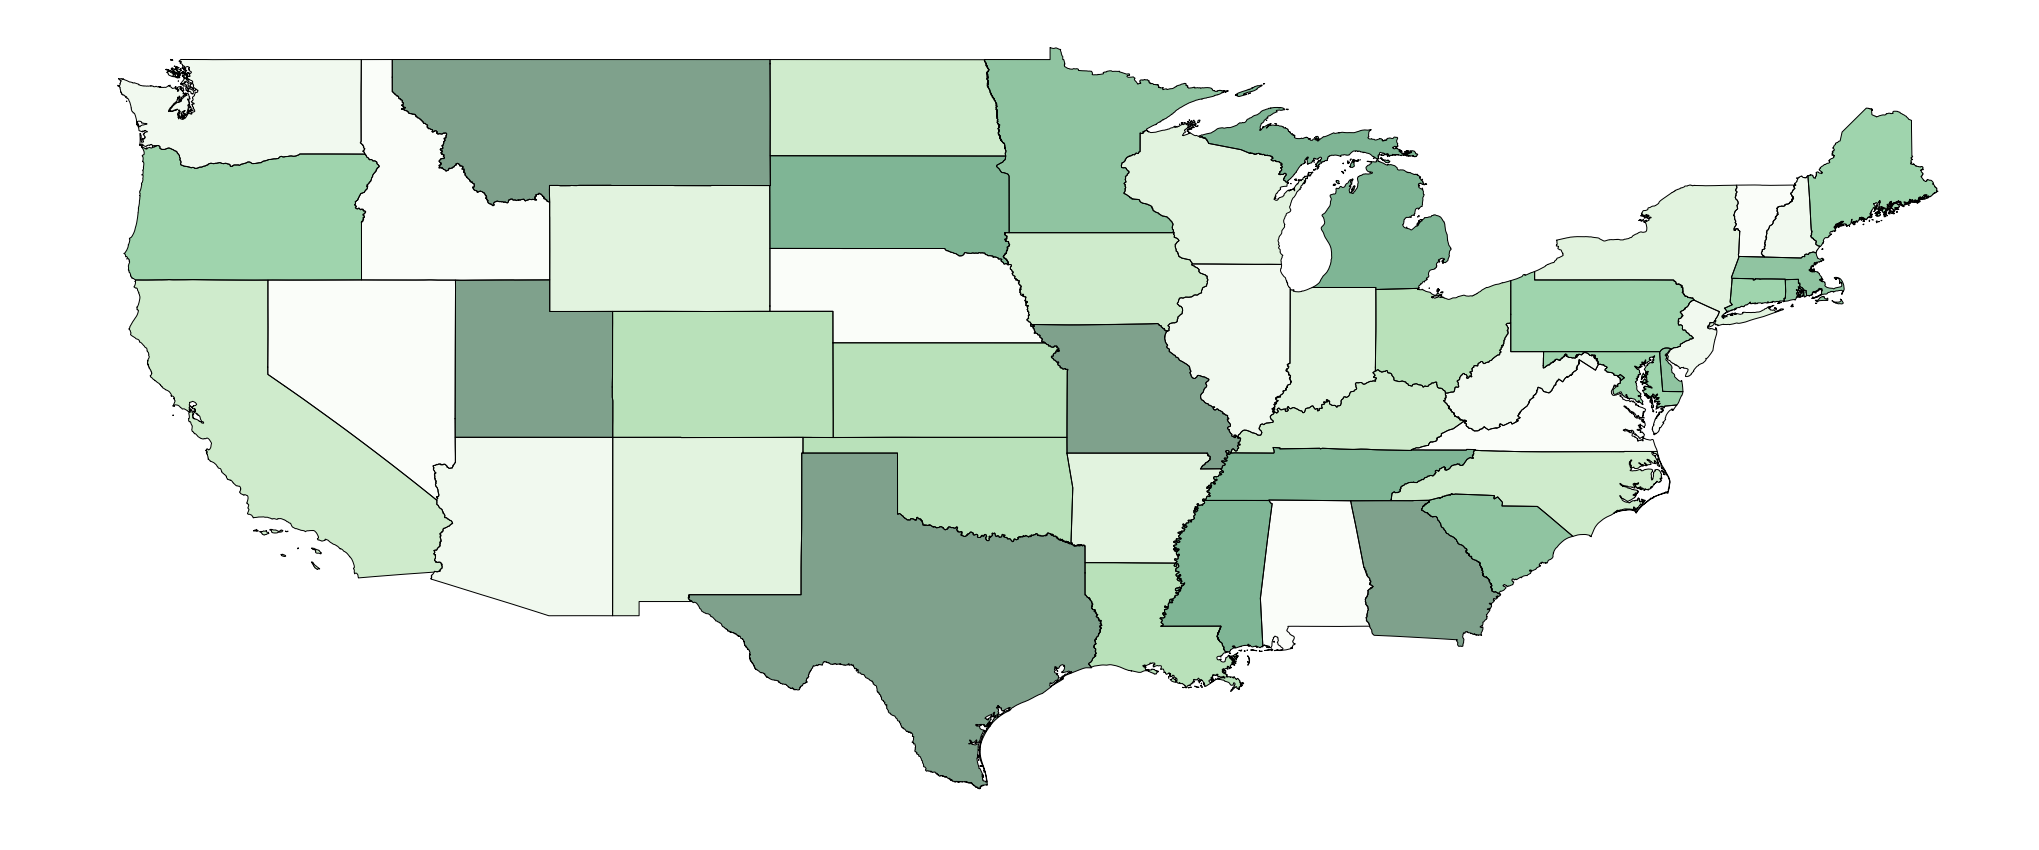

In [243]:
ax = states_with_most_popular.plot(figsize=(40,15), scheme='PrimSource', legend=True, cmap='Greens')
ax.axis('off')

### 6. Make a map of the power plants within 150 miles of New York City. I want it centered on New York City, zoomed in a good amount.

In [533]:
nyc_center = gpd.GeoDataFrame(geometry=[Point(-74.0, 40.7)])
nyc_center.crs = {'init': 'epsg:4326'}

In [534]:
nyc_center = nyc_center.to_crs({'init': 'epsg:3395'})
states = states.to_crs({'init': 'epsg:3395'})

In [535]:
#150 miles = 241402 meters
buffered_nyc_150 = nyc_center.buffer(241402)

In [536]:
powerplants = powerplants.to_crs({'init': 'epsg:3395'})

In [537]:
powerplants[powerplants.within(buffered_nyc.loc[0])]

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,Zip,Street_Add,PrimSource,...,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
344,542,Cos Cob,Connecticut Jet Power LLC,22379,IPP Non-CHP,Greenwich,Fairfield,6430,Sound Shore Drive,petroleum,...,0.0,NaN,NaN,Petroleum = 95.6 MW,Petroleum Liquids,"EIA-860, EIA-860M and EIA-923",201607,41.028900,-73.598900,POINT (-8192992.070945063 4988549.900230885)
362,568,Bridgeport Station,PSEG Power Connecticut LLC,15452,IPP Non-CHP,Bridgeport,Fairfield,6604,1 Atlantic Street,coal,...,0.0,NaN,NaN,"Coal = 383.4 MW, Petroleum = 16.9 MW",Conventional Steam Coal; Petroleum Liquids;,"EIA-860, EIA-860M and EIA-923",201607,41.170600,-73.184400,POINT (-8146850.142011249 5009402.536996176)
1148,2390,Sayreville,NRG REMA LLC,17235,IPP Non-CHP,Sayerville,Middlesex,8872,River Road,natural gas,...,0.0,NaN,NaN,"Natural Gas = 150 MW, Petroleum = 50 MW",Natural Gas Fired Combustion Turbine; Petroleu...,"EIA-860, EIA-860M and EIA-923",201607,40.476525,-74.352336,POINT (-8276864.182810382 4907690.43734255)
1150,2398,Bergen Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Ridgefield,Bergen,7657,Victoria Terrace,natural gas,...,0.0,NaN,NaN,Natural Gas = 1223 MW,Natural Gas Fired Combined Cycle,"EIA-860, EIA-860M and EIA-923",201607,40.837500,-74.024400,POINT (-8240358.514277601 4960455.04196529)
1152,2401,PSEG Essex Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Newark,Essex,7105,155 Raymond Boulevard,natural gas,...,0.0,NaN,NaN,Natural Gas = 81 MW,Natural Gas Fired Combustion Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.737200,-74.120600,POINT (-8251067.449291913 4945765.040610379)
1153,2403,PSEG Hudson Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Jersey City,Hudson,7306,Duffield and Van Keuren Avenue,natural gas,...,0.0,NaN,NaN,Natural Gas = 620 MW,Natural Gas Steam Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.747800,-74.072200,POINT (-8245679.585937518 4947316.467424468)
1154,2404,PSEG Kearny Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Kearny,Hudson,7032,Hackensack Avenue,natural gas,...,0.0,NaN,NaN,Natural Gas = 445 MW,Natural Gas Fired Combustion Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.737283,-74.096464,POINT (-8248380.642062126 4945777.187607316)
1155,2406,PSEG Linden Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Linden,Union,7036,Wood Avenue South,natural gas,...,0.0,NaN,NaN,Natural Gas = 1601.6 MW,Natural Gas Fired Combustion Turbine; Natural ...,"EIA-860, EIA-860M and EIA-923",201607,40.621700,-74.207200,POINT (-8260707.71719461 4928876.458336087)
1156,2408,PSEG Mercer Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Hamilton Township,Mercer,8611,Lamberton Road,coal,...,0.0,NaN,NaN,Coal = 632 MW,Conventional Steam Coal,"EIA-860, EIA-860M and EIA-923",201607,40.179200,-74.733900,POINT (-8319339.692995429 4864444.077381516)
1158,2411,PSEG Sewaren Generating Station,PSEG Fossil LLC,15147,IPP Non-CHP,Sewaren,Middlesex,7077,751 Cliff Road,natural gas,...,0.0,NaN,NaN,Natural Gas = 450.6 MW,Natural Gas Steam Turbine,"EIA-860, EIA-860M and EIA-923",201607,40.555800,-74.246900,POINT (-8265127.100979103 4919253.646925284)


(4600000, 5200000)

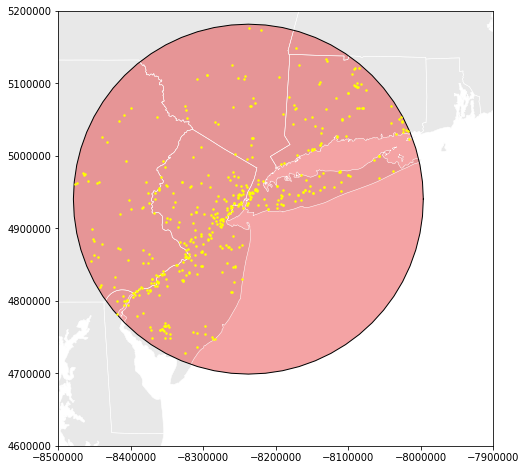

In [552]:
ax = states.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(20,8))
buffered_nyc_150.plot(alpha=0.4, ax=ax)
powerplants[powerplants.within(buffered_nyc_150.loc[0])].plot(markersize=1.5, color='yellow', ax=ax)
#ax.axis('off')
ax.set_xlim([-8500000, -7900000])
ax.set_ylim([4600000, 5200000])

### 7. Are places with below-average air quality closer to power plants? 

In [553]:
average = pm25['Arithmetic Mean'].mean()

In [556]:
pm25_below_average = gpd.GeoDataFrame(pm25[pm25['Arithmetic Mean'] <= average])

In [562]:
pm25_below_average.crs = {'init': 'epsg:4326'}

In [563]:
pm25_below_average = pm25_below_average.to_crs({'init': 'epsg:3395'})

In [593]:
# say, 'close' means within 50 miles buffer 
buffered_pm25_below_average = pm25_below_average.buffer(80467)

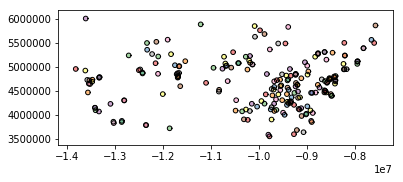

In [583]:
buffered_pm25_below_average.plot()

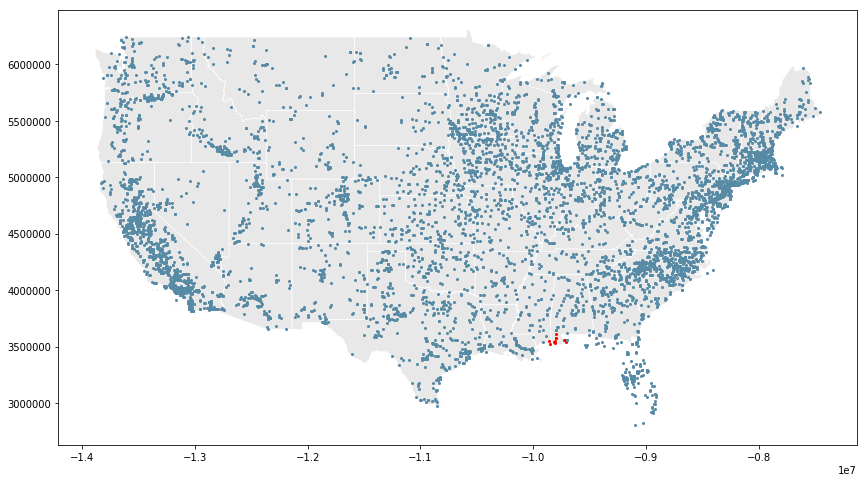

In [594]:
ax = states.plot(color='lightgrey', linewidth=0.5, edgecolor='white', figsize=(20,8))
powerplants[powerplants.within(buffered_pm25_below_average.loc[0])].plot(markersize=2, color='red', ax=ax)
powerplants[~powerplants.within(buffered_pm25_below_average.loc[0])].plot(markersize=2, color='#578aa5', ax=ax)